In [42]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

OUTPUT_FOLDER = '/mnt/s/data'

In [2]:
con = duckdb.connect('/mnt/s/learn2therm.ddb')

## Scatterplots of 16s read length vs proteome size

### All taxa

In [3]:
cmd = """SELECT "16s_len",
         temperature < 40 AS meso,
         (SELECT COUNT(taxid)
         FROM proteins
         WHERE taxid = taxa.taxid) AS num_prot
         FROM taxa
         """

proteins_vs_16s = con.execute(cmd).df()

In [4]:
proteins_vs_16s.head()

,16s_len,meso,num_prot
0,1589,True,3612
1,1589,True,0
2,1588,True,5269
3,1588,False,2240
4,1585,True,2099


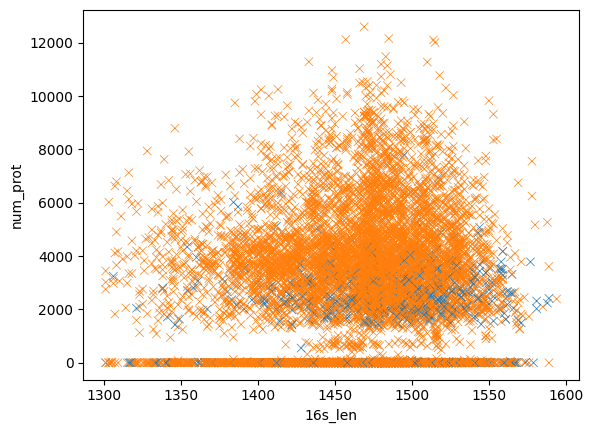

In [7]:
sns.scatterplot(data = proteins_vs_16s, x = '16s_len', y = 'num_prot', hue = 'meso', style = True, legend = False, markers = 'x');
# p_vs_16s_thermo = proteins_vs_16s[proteins_vs_16s['meso']==False]
# p_vs_16s_meso = proteins_vs_16s[proteins_vs_16s['meso']==True]
# p_vs_16s_thermo.to_csv(f'{OUTPUT_FOLDER}/p_vs_16s_thermo.csv')
# p_vs_16s_meso.to_csv(f'{OUTPUT_FOLDER}/l2t/p_vs_16s_meso.csv')

### Taxa with proteins

In [8]:
cmd = """SELECT "16s_len",
         temperature < 40 AS meso,
         (SELECT COUNT(taxid)
         FROM proteins
         WHERE taxid = taxa.taxid) AS num_prot
         FROM taxa
         WHERE num_prot >0
         """

proteins_vs_16s_clean = con.execute(cmd).df()

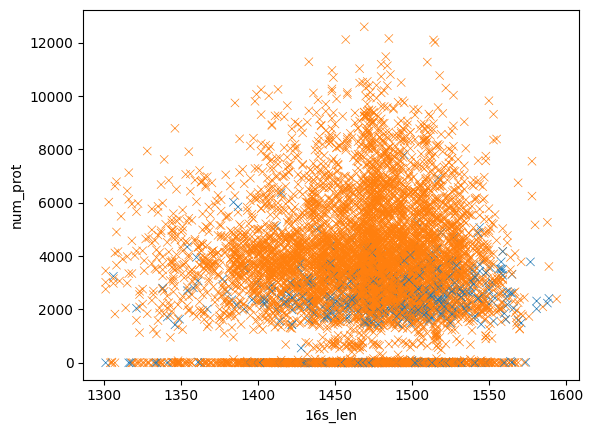

In [9]:
sns.scatterplot(data = proteins_vs_16s_clean, x = '16s_len', y = 'num_prot', hue = 'meso', style = True, legend = False, markers = 'x');
# p_vs_16s_thermo_cln = proteins_vs_16s_clean[proteins_vs_16s_clean['meso']==False]
# p_vs_16s_meso_cln = proteins_vs_16s_clean[proteins_vs_16s_clean['meso']==True]
# p_vs_16s_thermo_cln.to_csv(f'{OUTPUT_FOLDER}/p_vs_16s_thermo_cln.csv')
# p_vs_16s_meso_cln.to_csv(f'{OUTPUT_FOLDER}/p_vs_16s_meso_cln.csv')

### Taxa with 1-50 proteins

In [10]:
cmd = """SELECT "16s_len",
         temperature < 40 AS meso,
         (SELECT COUNT(taxid)
         FROM proteins
         WHERE taxid = taxa.taxid) AS num_prot
         FROM taxa
         WHERE num_prot <50
         AND num_prot >0
         """

proteins_vs_16s_low = con.execute(cmd).df()

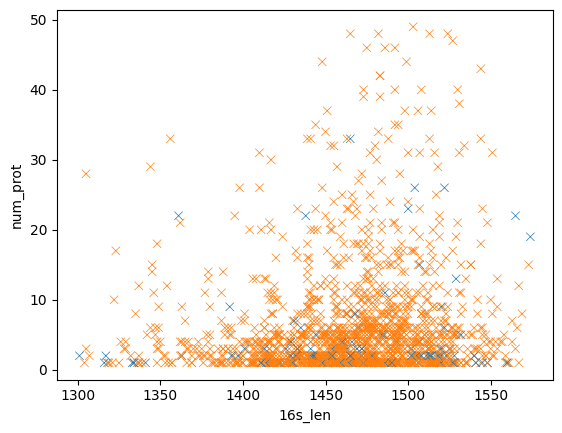

In [11]:
sns.scatterplot(data = proteins_vs_16s_low, x = '16s_len', y = 'num_prot', hue = 'meso', style = True, legend = False, markers = 'x');

In [18]:
print(f'Total number of taxa with proteins: {len(proteins_vs_16s)-len(proteins_vs_16s_clean)}')

Total number of taxa with proteins: 2037


### Proportion of proteins from taxa with >1000 proteins that are in pairs

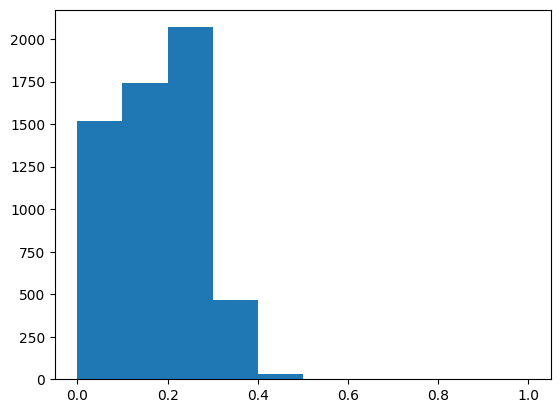

In [28]:
cmd = """SELECT taxid,
         (SELECT COUNT(taxid) FROM proteins
          WHERE taxa.taxid = proteins.taxid) 
          AS num_prot,
         (SELECT COUNT(DISTINCT meso_pid) FROM pairs
          WHERE taxa.taxid = pairs.meso_taxid) +
         (SELECT COUNT(DISTINCT thermo_pid) FROM pairs
          WHERE taxa.taxid = pairs.thermo_taxid) 
          AS num_in_pair
         FROM taxa
         WHERE num_prot >= 1000"""

prot_rep = con.execute(cmd).df()

prot_rep['prop'] = prot_rep['num_in_pair']/prot_rep['num_prot']

n, bins, _ = plt.hist(prot_rep['prop'], bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
data = {'Bins':bins[:-1], 'Counts':n}
prot_rep_taxa = pd.DataFrame(data)
#prot_rep_taxa.to_csv(f'{OUTPUT_FOLDER}/protein_rep_taxa_hist.csv')

### Remake scatterplot with only used proteins

In [29]:
m_cmd = """SELECT taxid,
         "16s_len",
         (SELECT COUNT(taxid) FROM proteins
          WHERE taxa.taxid = proteins.taxid) 
          AS num_prot,
         (SELECT COUNT(DISTINCT meso_pid) FROM pairs
          WHERE taxa.taxid = pairs.meso_taxid) 
          AS num_in_pair
         FROM taxa
         WHERE num_in_pair > 0
         """
t_cmd = """SELECT taxid,
         "16s_len",
         (SELECT COUNT(taxid) FROM proteins
          WHERE taxa.taxid = proteins.taxid) 
          AS num_prot,
         (SELECT COUNT(DISTINCT thermo_pid) FROM pairs
          WHERE taxa.taxid = pairs.thermo_taxid) 
          AS num_in_pair
         FROM taxa
         WHERE num_in_pair > 0
         """
m_used_prot_rep = con.execute(m_cmd).df()
t_used_prot_rep = con.execute(t_cmd).df()

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [30]:
m_used_prot_rep.head()

,taxid,16s_len,num_prot,num_in_pair
0,1449,1570,2384,832
1,1625,1570,1263,386
2,35787,1568,1692,488
3,97478,1568,1970,488
4,53444,1568,1407,406


In [174]:
# m_used_prot_rep.to_csv(f'{OUTPUT_FOLDER}/meso_used_protein_vs_16s_no_0.csv')
# t_used_prot_rep.to_csv(f'{OUTPUT_FOLDER}/thermo_used_protein_vs_16s_no_0.csv')

### 16S % ID match vs number of pairs

In [36]:
cmd = """SELECT scaled_local_symmetric_percent_id,
         (SELECT COUNT(meso_taxid)
          FROM pairs
          WHERE taxa_pairs.thermo_taxid = thermo_taxid
          AND taxa_pairs.meso_taxid = meso_taxid)
         AS num_pairs
         FROM taxa_pairs
         WHERE scaled_local_symmetric_percent_id > 0.85
         AND query_align_cov > 0.9
         AND subject_align_cov > 0.9
         """

taxa_match_vs_num_pairs = con.execute(cmd).df()

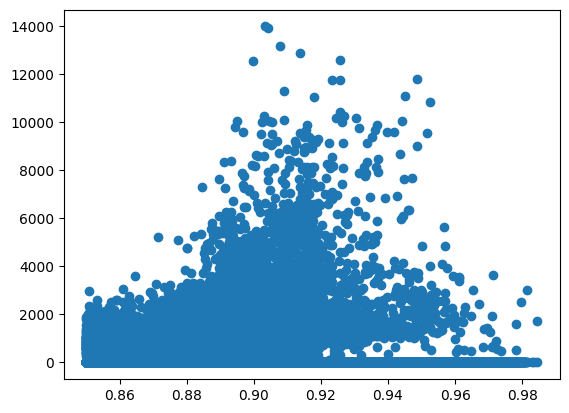

In [37]:
plt.scatter(taxa_match_vs_num_pairs['scaled_local_symmetric_percent_id'], taxa_match_vs_num_pairs['num_pairs'])

In [209]:
#taxa_match_vs_num_pairs.to_csv(f'{OUTPUT_FOLDER}/taxa_pairs_16S_id_vs_num_pairs.csv')

In [38]:
taxa_match_vs_num_pairs.shape

(105285, 2)

**Now scale for each pairwise space**

In [39]:
cmd = """SELECT scaled_local_symmetric_percent_id,
         (SELECT COUNT(meso_taxid)
          FROM pairs
          WHERE taxa_pairs.thermo_taxid = thermo_taxid
          AND taxa_pairs.meso_taxid = meso_taxid) AS num_pairs,
         (SELECT COUNT(taxid)
           FROM proteins
           WHERE taxa_pairs.thermo_taxid = proteins.taxid) AS t_hit,
         (SELECT COUNT(taxid)
          FROM proteins
          WHERE taxa_pairs.meso_taxid = proteins.taxid) AS m_hit
         FROM taxa_pairs
         WHERE scaled_local_symmetric_percent_id > 0.85
         AND query_align_cov > 0.9
         AND subject_align_cov > 0.9
         AND m_hit > 25
         AND t_hit > 25
         """

taxa_match_vs_num_pairs_scaled = con.execute(cmd).df()

In [40]:
taxa_match_vs_num_pairs_scaled['scaled_hit'] = taxa_match_vs_num_pairs_scaled['num_pairs'] / (taxa_match_vs_num_pairs_scaled['m_hit']
                                                                                             * taxa_match_vs_num_pairs_scaled['t_hit'])
taxa_match_vs_num_pairs_scaled.head()

,scaled_local_symmetric_percent_id,num_pairs,t_hit,m_hit,scaled_hit
0,0.939615,1433,2157,8775,0.000076
1,0.931434,1086,2157,6349,0.000079
2,0.935056,1517,2157,8237,0.000085
3,0.931389,1623,2157,8789,0.000086
4,0.932142,1018,2157,5906,0.000080


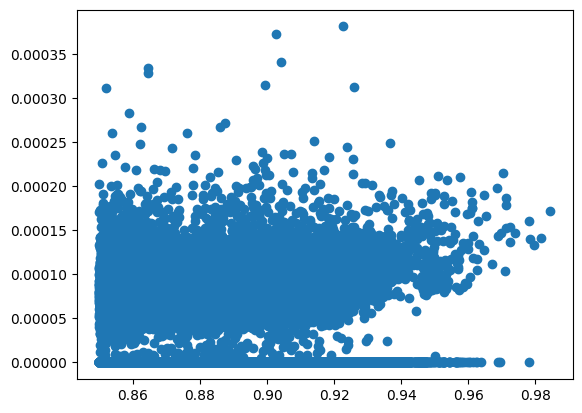

In [41]:
plt.scatter(taxa_match_vs_num_pairs_scaled['scaled_local_symmetric_percent_id'], taxa_match_vs_num_pairs_scaled['scaled_hit'])


In [250]:
#taxa_match_vs_num_pairs_scaled.to_csv(f'{OUTPUT_FOLDER}/taxa_pairs_16S_id_vs_num_pairs_scaled.csv')

### Spearman

In [43]:
res = stats.spearmanr(taxa_match_vs_num_pairs_scaled['scaled_local_symmetric_percent_id'], taxa_match_vs_num_pairs_scaled['scaled_hit'])

In [44]:
res.pvalue

0.0

In [45]:
res.statistic

0.16624594480035876